### Data Preparation

In [64]:
import pandas as pd

data_path = 'News AM Analiza Sentiment.csv'
data = pd.read_csv(data_path)

data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

print(data.head())

  Unnamed: 0       Date   Open   High    Low  Close  Adj Close     Volume  \
0  12/1/2006 2006-12-01  13.11  13.19  12.87  91.32      13.05  198769900   
1  12/4/2006 2006-12-04  13.13  13.15  12.93  91.12      13.02  177384200   
2  12/6/2006 2006-12-06  12.95  13.06  12.81  89.83      12.83  159546100   
3  12/7/2006 2006-12-07  12.86  12.93  12.41  87.04      12.43  251206900   
4  12/8/2006 2006-12-08  12.46  12.77  12.43  88.26      12.61  196069300   

                                                News Company Stock  sentiment  \
0  tonight 8 pm tlc ashley judd youthaids confron...   Apple  AAPL          1   
1  housing price broadest government measure hous...   Apple  AAPL          1   
2  honoring rw apple word food 1000 rw apple admi...   Apple  AAPL          1   
3  homebuilder worry job lead decline stock fell ...   Apple  AAPL          1   
4  homebuilder worry job lead decline stock fell ...   Apple  AAPL          1   

   Polarity Sentiment  
0      0.01   Neutral  
1 

### LSTM Model 1 - MA Polarity

In [65]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split


# Definirea mediei mobile
window_size = 60

# Crearea coloanelor cu media mobila
data['MA Close'] = data['Close'].rolling(window=window_size).mean()
data['MA Polarity'] = data['Polarity'].rolling(window=window_size).mean()

data.dropna(inplace=True)
# Normalizare
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['MA Polarity', 'MA Close']])  


X = []
y = []

sequence_length = 60 

for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i, 0:1])  
    y.append(data_scaled[i, 1])  

X, y = np.array(X), np.array(y)

# Impartirea setului de date
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definirea modelului
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Antrenarea modelului
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
80/80 [==============================] - 3s 19ms/step - loss: 0.0661 - val_loss: 0.0630
Epoch 2/50
80/80 [==============================] - 1s 14ms/step - loss: 0.0597 - val_loss: 0.0605
Epoch 3/50
80/80 [==============================] - 1s 14ms/step - loss: 0.0590 - val_loss: 0.0596
Epoch 4/50
80/80 [==============================] - 1s 14ms/step - loss: 0.0580 - val_loss: 0.0538
Epoch 5/50
80/80 [==============================] - 1s 14ms/step - loss: 0.0556 - val_loss: 0.0566
Epoch 6/50
80/80 [==============================] - 1s 14ms/step - loss: 0.0532 - val_loss: 0.0460
Epoch 7/50
80/80 [==============================] - 1s 14ms/step - loss: 0.0499 - val_loss: 0.0450
Epoch 8/50
80/80 [==============================] - 1s 14ms/step - loss: 0.0498 - val_loss: 0.0479
Epoch 9/50
80/80 [==============================] - 1s 14ms/step - loss: 0.0487 - val_loss: 0.0487
Epoch 10/50
80/80 [==============================] - 1s 14ms/step - loss: 0.0497 - val_loss: 0.0446
Epoch 11/

In [66]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt


predicted_MA_Close = model.predict(X_test)

# Evaluarea
mse = mean_squared_error(y_test, predicted_MA_Close)
rmse = sqrt(mse)


r2 = r2_score(y_test, predicted_MA_Close)


print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R-squared Score: {r2:.4f}')


23/23 [==============================] - 0s 4ms/step
Mean Squared Error: 0.0337
Root Mean Squared Error: 0.1837
R-squared Score: 0.5257


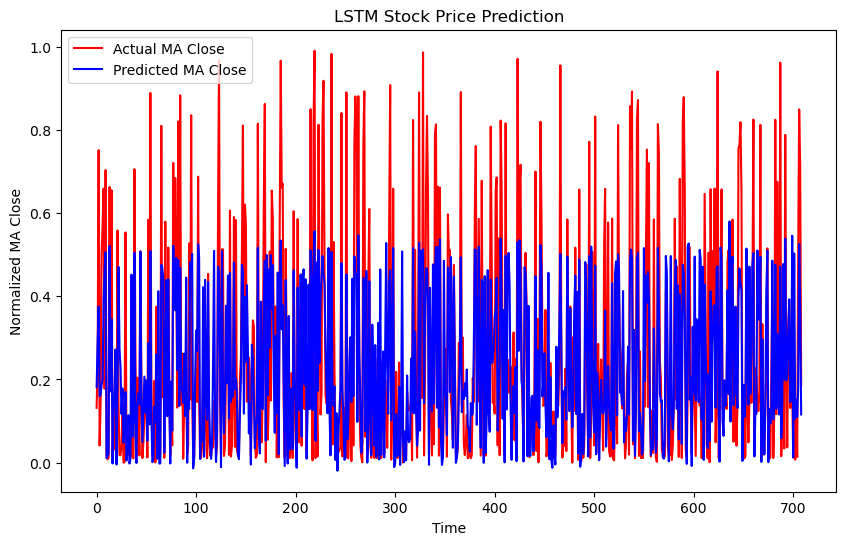

In [67]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(y_test, color='red', label='Actual MA Close')
plt.plot(predicted_MA_Close, color='blue', label='Predicted MA Close')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Normalized MA Close')
plt.legend()
plt.show()


### LSTM Model 2 - Improved

In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Incarcare date
data_path = 'News AM Analiza Sentiment.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Crearea coloanelor cu media mobila
window_size = 60
data['MA Close'] = data['Close'].rolling(window=window_size).mean()
data['MA Volume'] = data['Volume'].rolling(window=window_size).mean()
data['MA Polarity'] = data['Polarity'].rolling(window=window_size).mean()


data.dropna(inplace=True)

# Normalizare
scaler = MinMaxScaler(feature_range=(0, 1))
data[['MA Close', 'MA Volume', 'MA Polarity']] = scaler.fit_transform(data[['MA Close', 'MA Volume', 'MA Polarity']])

# Crearea secventelor
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[['MA Polarity', 'MA Volume']].iloc[i:(i + sequence_length)].values)
        y.append(data['MA Close'].iloc[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data, sequence_length)

# Impartirea setului de date
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
# Crearea modelului
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Antrenarea modelului
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)


Epoch 1/30
80/80 [==============================] - 3s 19ms/step - loss: 0.0655 - val_loss: 0.0533
Epoch 2/30
80/80 [==============================] - 1s 14ms/step - loss: 0.0438 - val_loss: 0.0332
Epoch 3/30
80/80 [==============================] - 1s 14ms/step - loss: 0.0356 - val_loss: 0.0249
Epoch 4/30
80/80 [==============================] - 1s 14ms/step - loss: 0.0310 - val_loss: 0.0222
Epoch 5/30
80/80 [==============================] - 1s 14ms/step - loss: 0.0296 - val_loss: 0.0240
Epoch 6/30
80/80 [==============================] - 1s 14ms/step - loss: 0.0299 - val_loss: 0.0234
Epoch 7/30
80/80 [==============================] - 1s 14ms/step - loss: 0.0288 - val_loss: 0.0248
Epoch 8/30
80/80 [==============================] - 1s 14ms/step - loss: 0.0290 - val_loss: 0.0212
Epoch 9/30
80/80 [==============================] - 1s 14ms/step - loss: 0.0270 - val_loss: 0.0201
Epoch 10/30
80/80 [==============================] - 1s 14ms/step - loss: 0.0282 - val_loss: 0.0229
Epoch 11/

In [54]:
# Przicere
predictions = model.predict(X_test)

# Evaluare
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions.flatten())

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared Score: {r2:.4f}')


23/23 [==============================] - 0s 4ms/step
Mean Squared Error: 0.0197
R-squared Score: 0.7057


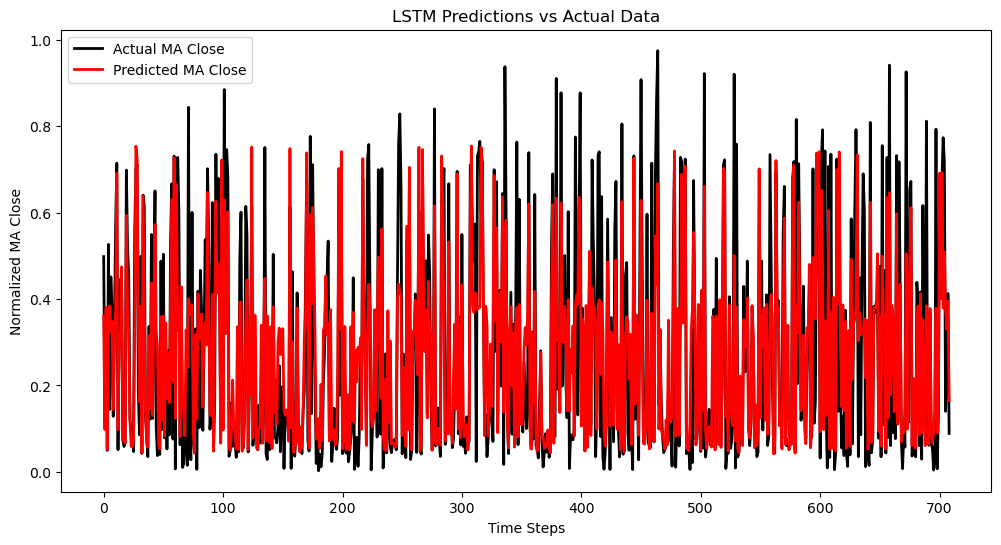

In [55]:
import matplotlib.pyplot as plt


predictions = predictions.flatten()

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual MA Close', color='black', linewidth=2)  
plt.plot(predictions, label='Predicted MA Close', color='red', linewidth=2)
plt.title('LSTM Predictions vs Actual Data')
plt.xlabel('Time Steps')
plt.ylabel('Normalized MA Close')
plt.legend()
plt.show()

### Random Forest

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Incarcare date
data_path = 'News AM Analiza Sentiment.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Crearea coloanelor cu media mobila
data['MA Close'] = data['Close'].rolling(window=60).mean()
data['MA Polarity'] = data['Polarity'].rolling(window=60).mean()
data['MA Volume'] = data['Volume'].rolling(window=60).mean()


data.dropna(inplace=True)


X = data[['MA Polarity','MA Volume']] 
y = data['MA Close']  

# Impartirea setului de date
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Crearea modelului
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Antrenarea modelului
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [14]:

predictions = rf.predict(X_test)

# Evaluarea
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared Score: {r2:.4f}')


Mean Squared Error: 3341.7441
R-squared Score: 0.7151


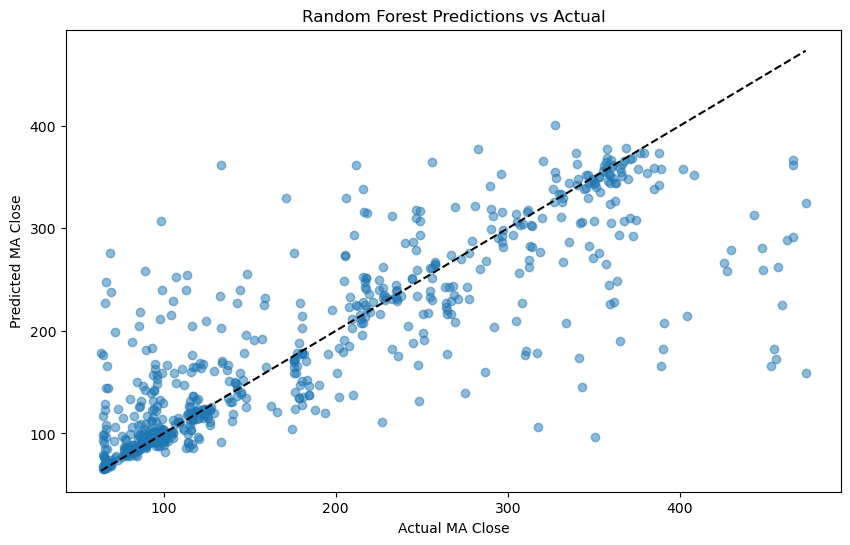

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Actual MA Close')
plt.ylabel('Predicted MA Close')
plt.title('Random Forest Predictions vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.show()


### KNN Model

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Incarcare date
data_path = 'News AM Analiza Sentiment.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Crearea coloanelor cu media mobila
data['MA Close'] = data['Close'].rolling(window=60).mean()
data['MA Polarity'] = data['Polarity'].rolling(window=60).mean()
data['MA Volume'] = data['Volume'].rolling(window=60).mean()


data.dropna(inplace=True)


X = data[['MA Polarity', 'MA Volume']]  
y = data['MA Close']       

# Impartirea setului de date
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Normalizare
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
# Crearea modelului
knn = KNeighborsRegressor(n_neighbors=5)

# Antrenarea modelului
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [19]:

predictions = knn.predict(X_test_scaled)

# Evaluarea
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared Score: {r2:.4f}')


Mean Squared Error: 3756.2527
R-squared Score: 0.6797


In [20]:
from sklearn.model_selection import GridSearchCV


param_grid = {'n_neighbors': range(1, 20)}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

best_knn = grid_search.best_estimator_
print(f'Best number of neighbors: {grid_search.best_params_}')

# Evaluarea optimizata
best_predictions = best_knn.predict(X_test_scaled)
best_mse = mean_squared_error(y_test, best_predictions)
best_r2 = r2_score(y_test, best_predictions)

print(f'Optimized Mean Squared Error: {best_mse:.4f}')
print(f'Optimized R-squared Score: {best_r2:.4f}')



Best number of neighbors: {'n_neighbors': 18}
Optimized Mean Squared Error: 3954.9636
Optimized R-squared Score: 0.6628


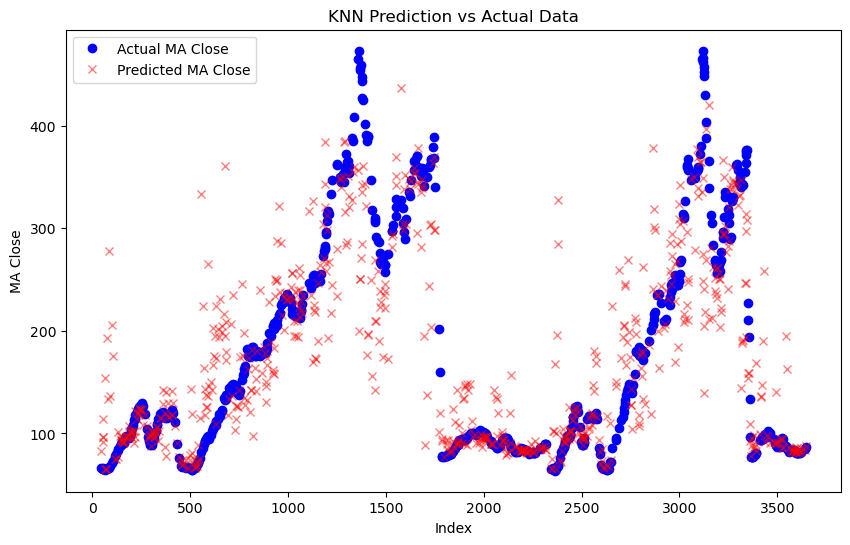

In [21]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual MA Close', color='blue', marker='o', linestyle='None')
plt.plot(y_test.index, predictions, label='Predicted MA Close', color='red', alpha=0.5, marker='x', linestyle='None')
plt.title('KNN Prediction vs Actual Data')
plt.xlabel('Index')
plt.ylabel('MA Close')
plt.legend()
plt.show()


### SVM Model

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Incarcare date
data_path = 'News AM Analiza Sentiment.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Crearea coloanelor cu media mobila
data['MA Close'] = data['Close'].rolling(window=60).mean()
data['MA Polarity'] = data['Polarity'].rolling(window=60).mean()
data['MA Volume'] = data['Volume'].rolling(window=60).mean()


data.dropna(inplace=True)


X = data[['MA Polarity', 'MA Volume']]  
y = data['MA Close']      

# Impartirea setului de da
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
# Normalizare
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
# Crearea modelului
svr = SVR(kernel='rbf', C=10, epsilon=0.01)

# Antrenarea modelului
svr.fit(X_train_scaled, y_train)


SVR(C=10, epsilon=0.01)

In [29]:

predictions = svr.predict(X_test_scaled)

# Evaluarea
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared Score: {r2:.4f}')


Mean Squared Error: 6332.1699
R-squared Score: 0.4601


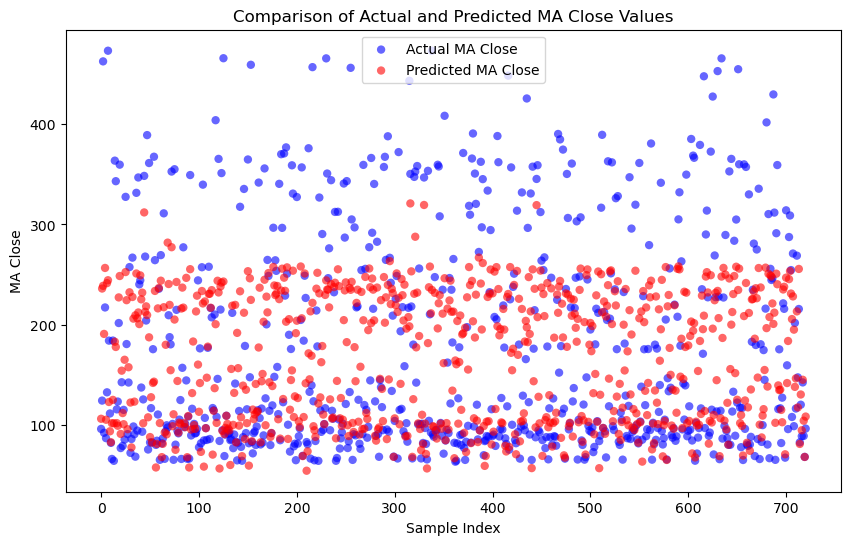

In [30]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual MA Close', alpha=0.6, edgecolors='none')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted MA Close', alpha=0.6, edgecolors='none')
plt.title('Comparison of Actual and Predicted MA Close Values')
plt.xlabel('Sample Index')
plt.ylabel('MA Close')
plt.legend()
plt.show()
